In [190]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS
c:\Dev\MinorProject\WDSS


In [191]:
import torch

from config import Settings, device
from commons import initialize
from utils.image_utils import ImageUtils
from network.losses import ImageEvaluator

In [192]:
settings = Settings('config/config.json', 'TEST')
initialize(settings)

Job: pp_relu_inr_only, Model: TEST, Device: cuda
Model path: out\pp_relu_inr_only-TEST\model
Log path: out\pp_relu_inr_only-TEST\logs


In [193]:
from network.dataset import *

# Load the dataset
train, val, test = WDSSDatasetCompressed.get_datasets(settings)

In [194]:
# Loader
loader = torch.utils.data.DataLoader(test, batch_size=8, shuffle=False, num_workers=0)
print(len(loader))

30


In [175]:
from network.dataset import *
from utils.masks import Mask

test = WDSSDatasetCompressed(settings.test_dir, 120, 0, 2, False, 8) 
print(len(test))

120


In [176]:
raw_frames = test._get_raw_frames(119)

In [177]:
def normalize_hdr(hdr_image, exposure=1.0):
    return 1.0 - torch.exp(-hdr_image * exposure)

def denomalize_hdr(hdr_image, exposure=1.0):
    return -torch.log(1.0 - hdr_image) / exposure

def aces_tonemap(image):
    A = 2.51
    B = 0.03
    C = 2.43
    D = 0.59
    E = 0.14
    return (image * (A * image + B)) / (image * (C * image + D) + E)

def linear_to_srgb(x):
    return torch.where(x <= 0.0031308, 12.92 * x, 1.055 * (x ** (1/2.4)) - 0.055)


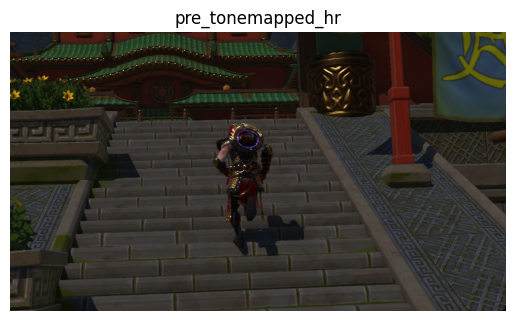

(tensor(0.), tensor(1.))

In [178]:
pre_tonemapped_hr = raw_frames[RawFrameGroup.HR_GB][GB_Type.PRE_TONEMAPPED]
pre_tonemapped_hr_normalized = normalize_hdr(pre_tonemapped_hr, 1.0)

pre_tonemapped_denormalized = denomalize_hdr(pre_tonemapped_hr_normalized, 1.0)

pre_tonemapped_hr = pre_tonemapped_hr_normalized
ImageUtils.display_image(pre_tonemapped_hr, 'pre_tonemapped_hr')
pre_tonemapped_hr.min(), pre_tonemapped_hr.max()

In [179]:
def brdf_demodulate(
    frame: torch.Tensor,
    brdf_map: torch.Tensor
) -> torch.Tensor:
    """Demodulate the frame using the BRDF map.
    """
    demodulated_frame = torch.where(brdf_map < 0.004, 0, frame / brdf_map)

    return demodulated_frame

def brdf_remodulate(
    frame: torch.Tensor,
    brdf_map: torch.Tensor
) -> torch.Tensor:
    """Remodulate the frame using the BRDF map.
    """
    remodulated_frame = torch.where(brdf_map < 0.004, 0, frame * brdf_map)

    return remodulated_frame


In [180]:
def compute_brdf(
    diffuse: torch.Tensor,
    roughness: torch.Tensor,
    metallic: torch.Tensor,
    specular: torch.Tensor,
    NoV: torch.Tensor,
    precomp: torch.Tensor
) -> torch.Tensor:
    """Demodulate the frame using the BRDF parameters.
    """
    nov_idx = (NoV * 511).long().clamp(0, 511)
    roughness_idx = (roughness * 511).long().clamp(0, 511)

    # Sample the pre-conputed BRDF lookup table
    pre_integration = precomp[0][nov_idx, roughness_idx]
    pre_integration_b = precomp[1][nov_idx, roughness_idx]

    # Compute specular reflactange
    specular = specular.expand(3, -1, -1)
    metallic = metallic.expand(3, -1, -1)

    # Compute the specular reflectance
    specular_color = torch.lerp(0.08 * specular, diffuse, metallic)

    # Calculate the BRDF
    brdf = diffuse * (1 - metallic) + pre_integration * specular_color + pre_integration_b.expand(3, -1, -1)
    return brdf


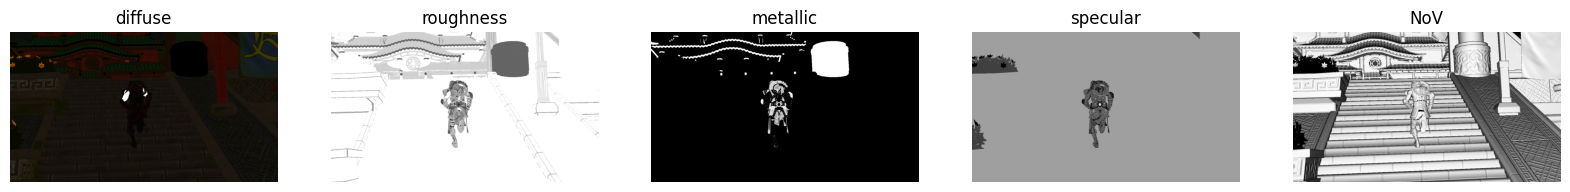

In [181]:
diffuse = raw_frames[RawFrameGroup.HR_GB][GB_Type.DIFFUSE_COLOR]
roughness = raw_frames[RawFrameGroup.HR_GB][GB_Type.ROUGHNESS]
metallic = raw_frames[RawFrameGroup.HR_GB][GB_Type.METALLIC]
specular = raw_frames[RawFrameGroup.HR_GB][GB_Type.SPECULAR]
NoV = raw_frames[RawFrameGroup.HR_GB][GB_Type.NoV]

# diffuse_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.DIFFUSE_COLOR]
# roughness_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.ROUGHNESS]
# metallic_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.METALLIC]
# specular_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.SPECULAR]
# NoV_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.NoV]

ImageUtils.display_images([diffuse, roughness, metallic, specular, NoV], ['diffuse', 'roughness', 'metallic', 'specular', 'NoV'])

tensor(0.0013) tensor(1.0496)


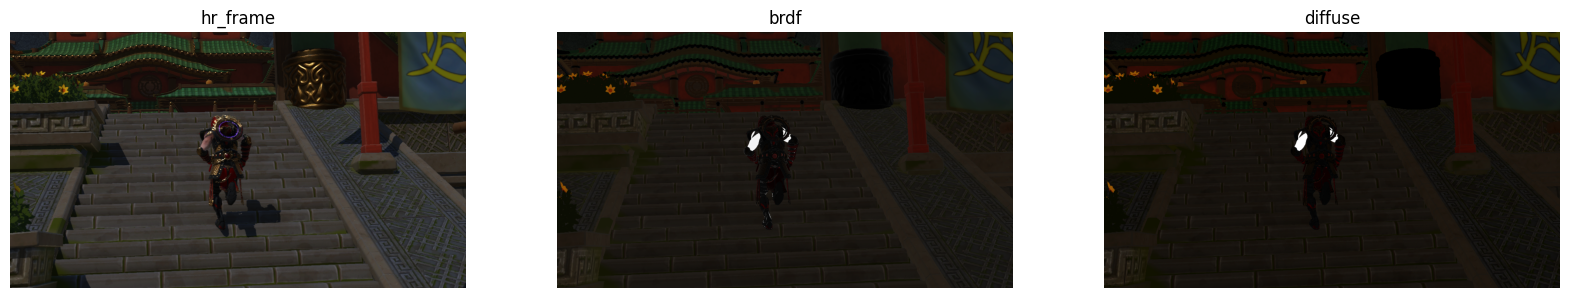

In [182]:
brdf = compute_brdf(diffuse, roughness, metallic, specular, NoV, test._precomputed_brdf)
# brdf = normalize_hdr(brdf)

# brdf = torch.nn.functional.softplus(brdf, 1)
# brdf = brdf.clamp(0, 1.0)
print(brdf.min(), brdf.max())

# brdf_lr = compute_brdf(diffuse_lr, roughness_lr, metallic_lr, specular_lr, NoV_lr, precomp)
# brdf_lr = torch.nn.functional.softplus(brdf_lr, 100)
# brdf_lr = ImageUtils.upsample(brdf.unsqueeze(0), 0.5).squeeze(0)

hr_frame = pre_tonemapped_hr


ImageUtils.display_images([hr_frame, brdf, diffuse], ['hr_frame', 'brdf', 'diffuse'])

# torch.min(brdf), torch.max(brdf), torch.min(brdf_lr), torch.max(brdf_lr)

tensor(0.) tensor(178.8402)
tensor(0.) tensor(1.)


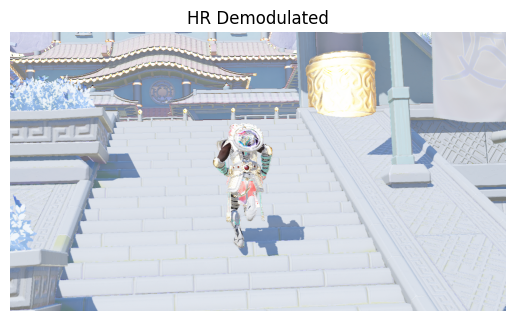

(tensor(0.), tensor(178.8402))

In [183]:


demodulated_hr = brdf_demodulate(hr_frame, brdf)

print(demodulated_hr.min(), demodulated_hr.max())

demodulated_hr_normalized = normalize_hdr(demodulated_hr, 1.0)
print(demodulated_hr_normalized.min(), demodulated_hr_normalized.max())

# demodulated_hr = denomalize_hdr(demodulated_hr_normalized, 1.0).clamp(0, 200.0)

ImageUtils.display_image(demodulated_hr_normalized, 'HR Demodulated')
demodulated_hr.min(), demodulated_hr.max()

tensor(0.) tensor(1.)


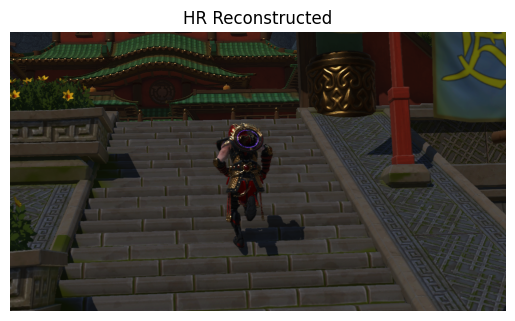

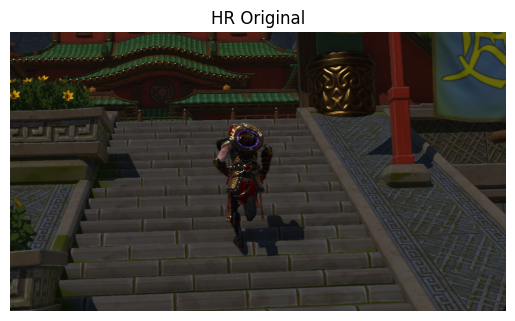

PSNR: 56.233463287353516, MSE: 2.3804211650713114e-06


In [184]:
# Reconstruct the frame
reconstructed_hr = brdf_remodulate(demodulated_hr, brdf).clamp(0, 1)
print(reconstructed_hr.min(), reconstructed_hr.max())
# reconstructed_lr = brdf_remodulate(demodulated_lr, brdf_lr)

ImageUtils.display_image(reconstructed_hr, 'HR Reconstructed', normalize=False)
ImageUtils.display_image(hr_frame, 'HR Original', normalize=False)

# Compute and display the loss
psnr = ImageEvaluator.psnr(reconstructed_hr, hr_frame)
mse = ImageEvaluator.mse(reconstructed_hr, hr_frame)
print(f'PSNR: {psnr}, MSE: {mse}')

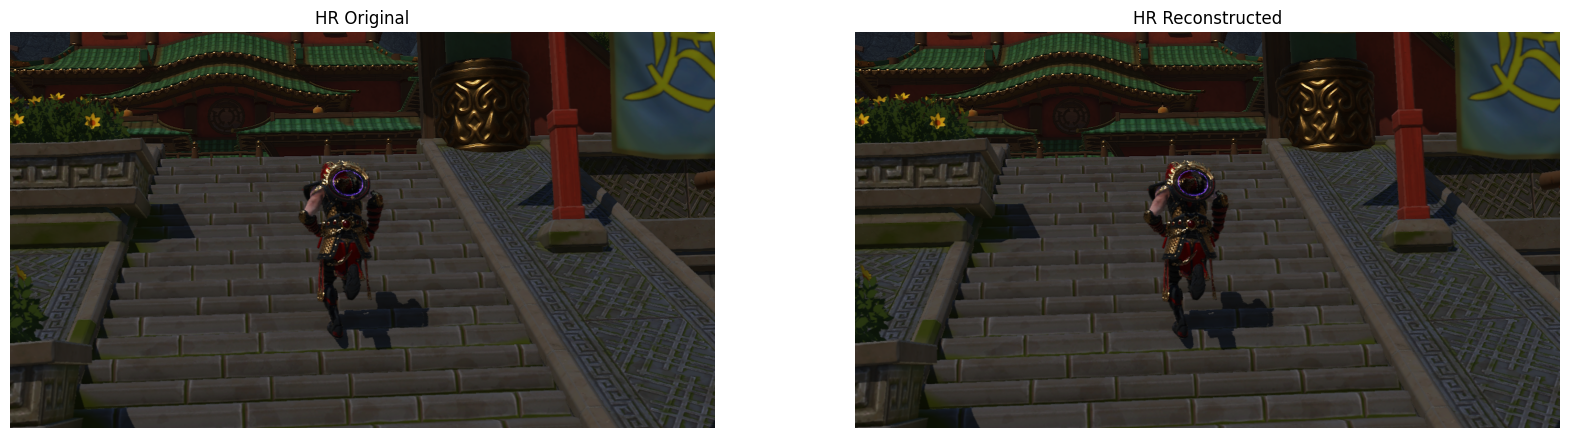

In [185]:
ImageUtils.display_images([hr_frame, reconstructed_hr], ['HR Original', 'HR Reconstructed'])

In [ ]:
# Upsample the demodulated lr frame and reconstruct it
upsampled_lr = ImageUtils.upsample(demodulated_lr.unsqueeze(0), 2, 'bilinear').squeeze(0)
reconstructed_upsampled_lr = brdf_remodulate(upsampled_lr, brdf).clamp(0, 1)

ImageUtils.display_image(reconstructed_upsampled_lr, normalize=False)

# Compute and display the loss
psnr = ImageEvaluator.psnr(reconstructed_upsampled_lr, hr_frame)
mse = ImageEvaluator.mse(reconstructed_upsampled_lr, hr_frame)
print(f'PSNR: {psnr}, MSE: {mse}')

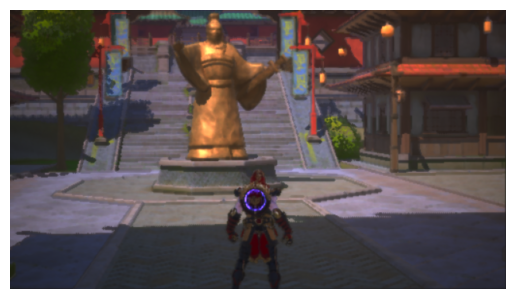

PSNR: 27.9232234954834, MSE: 0.001613160246051848


In [16]:
# Just simply upsample the lr frame and compute the loss
upsampled_lr = ImageUtils.upsample(lr_frame.unsqueeze(0), 2, 'bilinear').squeeze(0)

# Compute and display the loss
psnr = ImageEvaluator.psnr(upsampled_lr, hr_frame)
mse = ImageEvaluator.mse(upsampled_lr, hr_frame)

ImageUtils.display_image(upsampled_lr, normalize=False)
print(f'PSNR: {psnr}, MSE: {mse}')